# Importing Dependecies


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/Malaria_Cell_Dataset"
METRICS_PATH="/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/"
MODEL_NAME="MobileNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/Malaria_Cell_Dataset


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Parasitized', 'Uninfected']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        # print(img)
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        # print('Input image shape:', x.shape)
        img_data_list.append(x)

Loaded the images of dataset-Parasitized

Loaded the images of dataset-Uninfected



In [ ]:
img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(27558, 1, 32, 32, 3)
(1, 27558, 32, 32, 3)
(27558, 32, 32, 3)


# Train & Test Data

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:13780] = 1
labels[13780:] = 0
names = ['Parasitized', 'Uninfected']

sample 27558


In [ ]:
from sklearn.utils import shuffle
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [1]:
from  tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout

In [4]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Add a new classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
model.summary()
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# # x_train /= 255
# # x_test /= 255


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                           

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print(METRICS_PATH+MODEL_NAME+'.csv')

/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/MobileNet.csv


# Model Training

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.


<ipython-input-19-eb7f1dcb9614>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/100
1378/1378 [==============================] - 34s 18ms/step - loss: 0.6690 - accuracy: 0.6085 - f1: 0.6083 - specificity: 0.6086 - sensitivity: 0.6082 - val_loss: 0.6690 - val_accuracy: 0.6094 - val_f1: 0.6084 - val_specificity: 0.6084 - val_sensitivity: 0.6084 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 22s 16ms/step - loss: 0.6476 - accuracy: 0.6281 - f1: 0.6281 - specificity: 0.6281 - sensitivity: 0.6281 - val_loss: 0.6610 - val_accuracy: 0.6089 - val_f1: 0.6078 - val_specificity: 0.6078 - val_sensitivity: 0.6078 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 23s 17ms/step - loss: 0.6359 - accuracy: 0.6354 - f1: 0.6353 - specificity: 0.6353 - sensitivity: 0.6353 - val_loss: 0.6552 - val_accuracy: 0.6127 - val_f1: 0.6122 - val_specificity: 0.6122 - val_sensitivity: 0.6122 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 22s 16ms/step - loss: 0.6317 - accuracy: 0.6342 - f1: 0.6342 - specificit

# Results

In [ ]:

print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 3011.579649209976
173/173 [==============================] - 1s 7ms/step - loss: 0.6344 - accuracy: 0.6348 - f1: 0.6342 - specificity: 0.6342 - sensitivity: 0.6342
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.6690253019332886, 0.6476189494132996, 0.6359120011329651, 0.6317322850227356, 0.6267498135566711, 0.6299973130226135, 0.6288485527038574, 0.622409462928772, 0.6227353811264038, 0.6191838979721069, 0.6200960874557495, 0.6194766163825989, 0.6192419528961182, 0.617282509803772, 0.6184824109077454, 0.6142264604568481, 0.6171616315841675, 0.6187127828598022, 0.6148141622543335, 0.6131018400192261, 0.6144052743911743, 0.616923451423645, 0.6119323372840881, 0.6086018085479736, 0.6112335920333862, 0.6133341193199158, 0.6106823682785034, 0.6123928427696228, 0.6138391494750977, 0.6106119751930237, 0.6140689849853516, 0.6122851371765

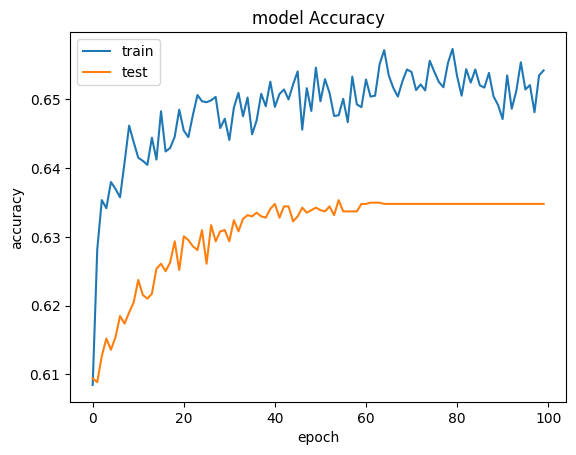

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


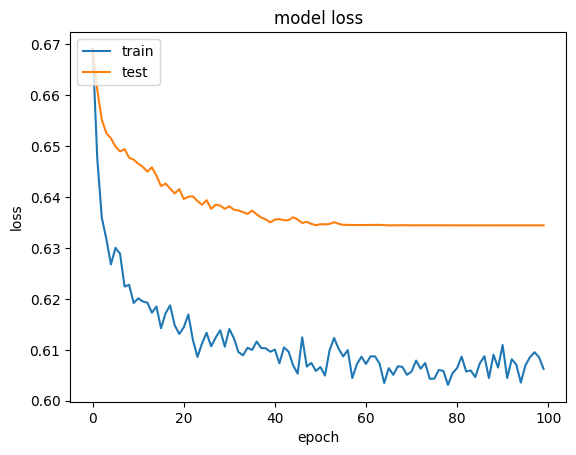

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


# without aug

In [ ]:
MODEL_NAME="MobileNet_waug"

In [ ]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Add a new classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255


In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])


In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Not using data augmentation.
Epoch 1/100
1378/1378 [==============================] - 18s 11ms/step - loss: 0.6759 - accuracy: 0.6150 - f1: 0.6148 - specificity: 0.6150 - sensitivity: 0.6148 - val_loss: 0.6665 - val_accuracy: 0.6150 - val_f1: 0.6149 - val_specificity: 0.6149 - val_sensitivity: 0.6149 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 13s 9ms/step - loss: 0.6593 - accuracy: 0.6218 - f1: 0.6218 - specificity: 0.6218 - sensitivity: 0.6218 - val_loss: 0.6546 - val_accuracy: 0.6181 - val_f1: 0.6179 - val_specificity: 0.6179 - val_sensitivity: 0.6179 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 13s 10ms/step - loss: 0.6504 - accuracy: 0.6263 - f1: 0.6263 - specificity: 0.6263 - sensitivity: 0.6263 - val_loss: 0.6488 - val_accuracy: 0.6206 - val_f1: 0.6205 - val_specificity: 0.6205 - val_sensitivity: 0.6205 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 15s 11ms/step - loss: 0.6457 - accuracy: 0.62

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 1587.7419550418854
173/173 [==============================] - 2s 10ms/step - loss: 0.6268 - accuracy: 0.6448 - f1: 0.6441 - specificity: 0.6441 - sensitivity: 0.6441
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.6758625507354736, 0.6592728495597839, 0.6504240036010742, 0.6456941962242126, 0.6424293518066406, 0.6410150527954102, 0.6396037936210632, 0.638145923614502, 0.6365436911582947, 0.6363118886947632, 0.6354089975357056, 0.6341062784194946, 0.6331925392150879, 0.632620632648468, 0.6313127279281616, 0.6307551860809326, 0.630828320980072, 0.6293439269065857, 0.6293790936470032, 0.6282535195350647, 0.6284653544425964, 0.6273468732833862, 0.6273253560066223, 0.6265189051628113, 0.6262222528457642, 0.626046359539032, 0.625275731086731, 0.6251228451728821, 0.6247920393943787, 0.6240731477737427, 0.6237953901290894, 0.6234640479087

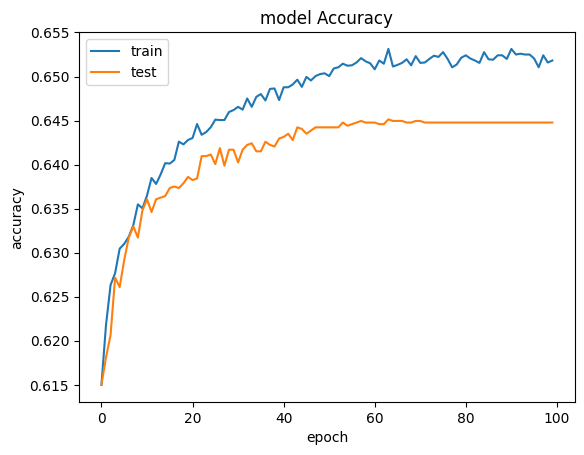

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


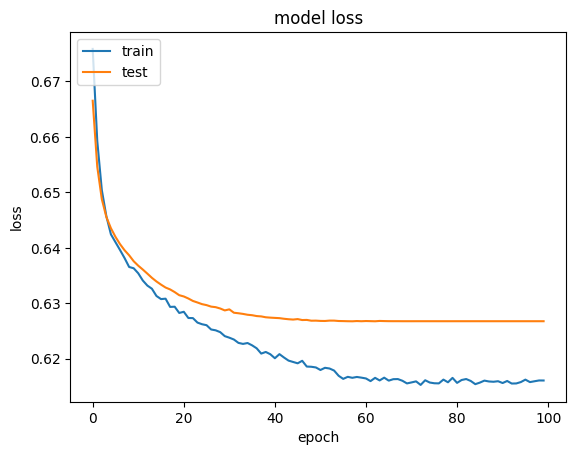

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
